In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
import random
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,Reshape,Input,MaxPooling2D,LeakyReLU,GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
import tensorflow as tf
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay, auc, f1_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt 
from imblearn.over_sampling import SMOTE


In [2]:
tf.random.set_seed(42)
np.random.seed(42)

# Load Data

In [3]:
X_train = pd.read_pickle('X_train.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_test = pd.read_pickle('y_test.pkl')

In [4]:
print(f"Training dataset size: {X_train.shape, y_train.shape}")
print(f"Test dataset size: {X_test.shape, y_test.shape}")

Training dataset size: ((1482238, 99), (1482238, 1))
Test dataset size: ((635245, 99), (635245, 1))


In [5]:
class_mapping = {
    'Normal': 12,  # Assuming 12 is the label for Normal
    'Backdoor': 0,
    'DDoS_HTTP': 1,
    'DDoS_ICMP': 2,
    'DDoS_TCP': 3,
    'OS_Fingerprinting': 4,
    'Password': 5,
    'Port_Scanning': 6,
    'Ransomware': 7,
    'SQL_injection': 8,
    'Uploading': 9,
    'Vulnerability_scanner': 10,
    'XSS': 11}

## Group by time and destination ip

In [ ]:
def preprocess_data(X, y):
    # additional preprocessing for CNN

    # Concatenate X and y 
    df = pd.concat([X, y], axis=1)
    df['ip.dst_host'] = df['ip.dst_host'].astype('category')

    # Group categorical and boolean columns
    categorical_cols = ['ip.src_host', 'tcp.dstport', 'tcp.srcport'] + df.select_dtypes(include=['boolean']).columns.tolist()
    exclude = categorical_cols + ['Attack_type', 'frame.time', 'ip.dst_host']
    
    # Grouping
    numerical_cols = [col for col in df.columns if col not in exclude]
    aggregation_functions = {
        **{col: 'mean' for col in numerical_cols},
        **{col: lambda x: x.mode().iloc[0] if not x.mode().empty else 0 for col in categorical_cols}
    }

    # Change attack_types to multi-label vectors to handle cases where > 1 attack 
    # in the same 0.1 second and ip.dst_host
    def create_attack_vector(y_series):
        attack_vector = np.zeros(13, dtype=int)
        unique_labels = np.unique(y_series)
        attack_vector[unique_labels] = 1
        return attack_vector

    grouped_df = df.groupby(['ip.dst_host', 'frame.time'], observed=True).agg(aggregation_functions).reset_index()
    y_grouped = df.groupby(['ip.dst_host', 'frame.time'], observed=True)['Attack_type'].apply(create_attack_vector).reset_index()
    
    # Format y
    y_grouped['Attack_type'] = y_grouped['Attack_type'].apply(lambda x: x if isinstance(x, np.ndarray) else np.zeros(13, dtype=int))
    unlist_y = pd.DataFrame(y_grouped['Attack_type'].tolist(), columns=[f'attack_{i}' for i in range(13)])
    y_grouped = pd.concat([y_grouped, unlist_y], axis=1)
    y_grouped = y_grouped.drop(columns=['Attack_type'])

    return grouped_df, y_grouped

## Evaluation Metrics

In [9]:
def plot_roc_curve(y_true, y_pred, n_classes):
    # Binarize the output
    lb = LabelBinarizer()
    y_true = lb.fit_transform(y_true)
    y_pred = lb.transform(y_pred)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
             color='deeppink', linewidth=2)

    plt.plot(fpr["macro"], tpr["macro"],
             label=f'macro-average ROC curve (area = {roc_auc["macro"]:0.2f})',
             color='navy', linewidth=2)

    colors = ['red', 'green', 'purple', 'brown', 'pink', 'gray', 'olive',
              'cyan', 'orange', 'yellow', 'black', 'blue', 'magenta']

    for i, color in zip(range(n_classes), colors):
        class_name = lb.classes_[i]
        plt.plot(fpr[i], tpr[i], color=color, lw=1,
                 label=f'ROC curve of {class_name} (area = {roc_auc[i]:0.2f})',
                 linestyle='--')


    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()


## Conv2D

In [ ]:
def create_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(128, (7, 7), padding='same'),  
        LeakyReLU(negative_slope=0.3),
        Dropout(0.3),
        Conv2D(64, (5, 5), padding='same'), 
        LeakyReLU(negative_slope=0.3),
        Dropout(0.3),
        GlobalAveragePooling2D(),  
        Dense(128),
        LeakyReLU(negative_slope=0.3),
        Dropout(0.3),
        Dense(100*13, activation='sigmoid'),  
        Reshape((100, 13))
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), 
                 loss='binary_crossentropy', 
                 metrics=['accuracy'])
    return model

In [12]:
# Preprocess the data
CNN2D_X_train, CNN2D_y_train = preprocess_data(X_train, y_train)
CNN2D_X_test, CNN2D_y_test = preprocess_data(X_test, y_test)

In [13]:
print(CNN2D_X_train.shape)
print(CNN2D_y_train.shape)
print(CNN2D_X_test.shape)
print(CNN2D_y_test.shape)

(308571, 99)
(308571, 15)
(222700, 99)
(222700, 15)


In [18]:
CNN2D_X_train.groupby(['ip.dst_host'])['frame.time'].nunique()

C:\Users\Gram\AppData\Local\Temp\ipykernel_15228\885629088.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  CNN2D_X_train.groupby(['ip.dst_host'])['frame.time'].nunique()


ip.dst_host
-1.412408     68858
-0.869346     58863
-0.773958         5
-0.742953      3374
-0.647114       246
-0.593919        10
-0.554964       245
-0.511440       170
-0.323277      2624
-0.305718         2
-0.285570      4441
 0.053789         1
 0.137657         8
 0.146755        21
 0.206199        21
 0.208993        14
 0.830206    169668
Name: frame.time, dtype: int64

In [28]:
CNN2D_X_train = CNN2D_X_train.astype({col: 'float64' for col in X_train.select_dtypes(include=['boolean']).columns})
CNN2D_X_test = CNN2D_X_test.astype({col: 'float64' for col in X_test.select_dtypes(include=['boolean']).columns})

In [ ]:
reference_date = CNN2D_X_train['frame.time'].min()
CNN2D_X_train['frame.time']=(CNN2D_X_train['frame.time'] - reference_date).dt.total_seconds()

CNN2D_X_train.dtypes

ip.dst_host            category
frame.time              float64
icmp.checksum           float64
icmp.seq_le             float64
http.content_length     float64
                         ...   
was                     float64
ip.src_host             float64
tcp.dstport             float64
tcp.srcport             float64
tcp.flags.ack           float64
Length: 99, dtype: object

In [42]:
reference_date = CNN2D_X_test['frame.time'].min()
CNN2D_X_test['frame.time']=(CNN2D_X_test['frame.time'] - reference_date).dt.total_seconds()

CNN2D_X_test.dtypes

ip.dst_host            category
frame.time              float64
icmp.checksum           float64
icmp.seq_le             float64
http.content_length     float64
                         ...   
was                     float64
ip.src_host             float64
tcp.dstport             float64
tcp.srcport             float64
tcp.flags.ack           float64
Length: 99, dtype: object

In [45]:
reference_date = CNN2D_y_train['frame.time'].min()
CNN2D_y_train['frame.time']=(CNN2D_y_train['frame.time'] - reference_date).dt.total_seconds()

reference_date = CNN2D_y_test['frame.time'].min()
CNN2D_y_test['frame.time']=(CNN2D_y_test['frame.time'] - reference_date).dt.total_seconds()
print(CNN2D_y_train.dtypes, CNN2D_y_test.dtypes)

ip.dst_host    category
frame.time      float64
attack_0          int32
attack_1          int32
attack_2          int32
attack_3          int32
attack_4          int32
attack_5          int32
attack_6          int32
attack_7          int32
attack_8          int32
attack_9          int32
attack_10         int32
attack_11         int32
attack_12         int32
dtype: object ip.dst_host    category
frame.time      float64
attack_0          int32
attack_1          int32
attack_2          int32
attack_3          int32
attack_4          int32
attack_5          int32
attack_6          int32
attack_7          int32
attack_8          int32
attack_9          int32
attack_10         int32
attack_11         int32
attack_12         int32
dtype: object


In [ ]:
def sliding_window_samples(data, T, overlap=0.5):
    step = int(T * (1 - overlap))  # Calculate the step size for the overlap
    windows = [data[i:i+T] for i in range(0, len(data) - T + 1, step)]
    
    # Ensure each window has exactly T time steps by padding if needed
    padded_windows = []
    for window in windows:
        if len(window) < T:
            window = pad_sequences([window], maxlen=T, dtype='float32', padding='post')[0]
        padded_windows.append(window)
    
    return np.array(padded_windows)

def preprocess_and_reshape_data(X, y, T, overlap=0.5):

    all_X_windows = []
    all_y_windows = []
    
    # Process each IP group
    for ip in X['ip.dst_host'].unique():
        # Get corresponding data for this IP
        X_group = X[X['ip.dst_host'] == ip].drop(columns=['ip.dst_host', 'frame.time'], errors='ignore').to_numpy()
        y_group = y[y['ip.dst_host'] == ip].drop(columns=['ip.dst_host', 'frame.time'], errors='ignore').to_numpy()
        
        if len(X_group) < T:
            # Pad if smaller than window size
            X_padded = pad_sequences([X_group], maxlen=T, dtype='float32', padding='post')[0]
            y_padded = pad_sequences([y_group], maxlen=T, dtype='float32', padding='post')[0]
            all_X_windows.append(X_padded)
            all_y_windows.append(y_padded)  # Keep temporal dimension for y
        else:
            # Create windows
            X_windows = sliding_window_samples(X_group, T, overlap)
            y_windows = sliding_window_samples(y_group, T, overlap)
            
            all_X_windows.extend(X_windows)
            all_y_windows.extend(y_windows)  # Keep full windows for y
    
    # Convert to numpy arrays
    X_tensor = np.array(all_X_windows)
    y_tensor = np.array(all_y_windows)
    
    # Reshape X to (num_windows, 1, T, features)
    X_tensor = X_tensor.reshape(-1, 1, T, X.shape[1] - 2)
    
    # y_tensor should already be in shape (num_windows, T, 13)
    if len(y_tensor.shape) == 2:
        num_windows = y_tensor.shape[0] // T
        y_tensor = y_tensor.reshape(num_windows, T, 13)
    
    return X_tensor.astype(np.float32), y_tensor.astype(np.float32)

T = 100  
X_train_tensor, y_train_tensor = preprocess_and_reshape_data(CNN2D_X_train, CNN2D_y_train, T)
X_test_tensor, y_test_tensor = preprocess_and_reshape_data(CNN2D_X_test, CNN2D_y_test, T)

# Check shapes
print("X_train_tensor shape:", X_train_tensor.shape)  # Should be (num_windows, 1, T, num_features)
print("y_train_tensor shape:", y_train_tensor.shape)  # Should be (num_windows, T, 13)

X_train_tensor shape: (6164, 1, 100, 97)
y_train_tensor shape: (6164, 100, 13)


## Run the model

In [74]:
# Build and train the model
input_shape = (X_train_tensor.shape[1], X_train_tensor.shape[2], X_train_tensor.shape[3])
model = create_model(input_shape)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)  

CNN2D_hist = model.fit(X_train_tensor, y_train_tensor, validation_split=0.2, epochs=100, batch_size=128, 
                        callbacks=[early_stopping, reduce_lr])

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.1960 - loss: 0.4929 - val_accuracy: 1.0000 - val_loss: 0.0127 - learning_rate: 0.0010
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.6832 - loss: 0.1383 - val_accuracy: 1.0000 - val_loss: 1.5670e-04 - learning_rate: 0.0010
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.7069 - loss: 0.1164 - val_accuracy: 1.0000 - val_loss: 3.1979e-04 - learning_rate: 0.0010
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.7289 - loss: 0.1042 - val_accuracy: 1.0000 - val_loss: 1.3696e-04 - learning_rate: 0.0010
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - accuracy: 0.7855 - loss: 0.0864 - val_accuracy: 1.0000 - val_loss: 9.4598e-06 - learning_rate: 0.0010
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.7997 - loss: 0.0763 - val_accuracy: 1.0000 - val_loss: 8.9211e-07 - learning_rate: 0.0010
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.

In [75]:
# Evaluation
y_pred = model.predict(X_test_tensor)

140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [ ]:
y_pred_binary = (y_pred >= 0.5).astype(int) 

                       precision    recall  f1-score   support

             Backdoor       0.89      0.21      0.34     14667
            DDoS_HTTP       0.76      0.77      0.76      5573
            DDoS_ICMP       0.99      0.99      0.99     11822
             DDoS_TCP       0.97      0.99      0.98     16908
    OS_Fingerprinting       0.00      0.00      0.00       587
             Password       0.76      0.88      0.82     74057
        Port_Scanning       0.68      0.14      0.23     13360
           Ransomware       0.88      0.54      0.67      5918
        SQL_injection       1.00      0.96      0.98      8018
            Uploading       0.00      0.00      0.00      2737
Vulnerability_scanner       0.91      0.97      0.94     22570
                  XSS       0.00      0.00      0.00      5200
               Normal       1.00      1.00      1.00    270755

            micro avg       0.94      0.90      0.92    452172
            macro avg       0.68      0.57      0.59 

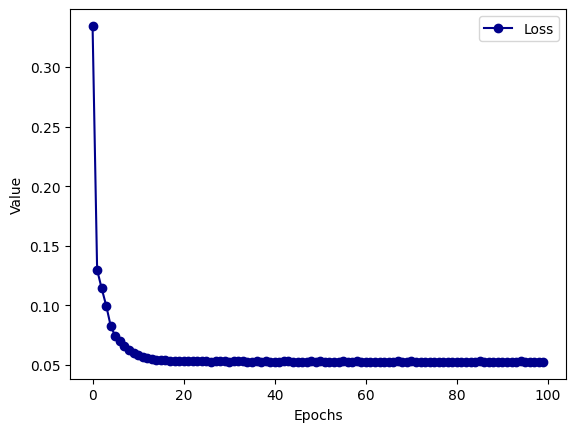

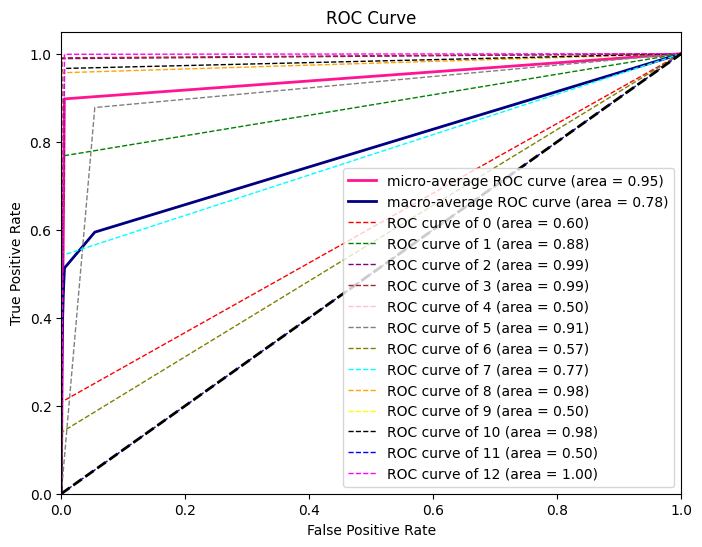

In [81]:
# Generate classification report
y_test_reshape = y_test_tensor.reshape(-1, 13)
y_pred_binary_reshape = y_pred_binary.reshape(-1, 13)

target_names = ['Backdoor', 'DDoS_HTTP', 'DDoS_ICMP', 'DDoS_TCP', 'OS_Fingerprinting',
                'Password', 'Port_Scanning', 'Ransomware', 'SQL_injection', 'Uploading', 
                'Vulnerability_scanner', 'XSS', 'Normal']
report = classification_report(y_test_reshape, y_pred_binary_reshape, target_names=target_names, zero_division=0)
print(report)

# plot loss
plt.plot(CNN2D_hist.history['loss'], label='Loss', marker='o', color='darkblue')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot roc curve
plot_roc_curve(y_test_reshape, y_pred_binary_reshape, n_classes=len(np.unique(y_test)))

In [84]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 1, 100, 128)    │       608,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 1, 100, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1, 100, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 1, 100, 64)     │       204,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 1, 100, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1, 100, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1300)           │       167,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 100, 13)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,968,190 (11.32 MB)

 Trainable params: 989,396 (3.77 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,978,794 (7.55 MB)